# Geotagged and Mentioned

In [2]:
############### GEOTAGGED AND MENTIONED ####################

# get distances column from all datasets
# first determine if there are any duplicate tweet ids in there
"""
import pandas as pd
import tqdm

distances = []

for i in tqdm.tqdm(range(0, 112)):
    df = pd.read_feather("s3://mt5599/final/processed_tweets_" + str(i) + ".feather")
    
    # keep only tweets with distances
    ddf = df[pd.notnull(df.coordinates_longitude) & (df.ner_type == "LOC")].reset_index(drop=True)
    ddf.to_feather("s3://mt5599/dissertation/distances_df_" + str(i) + ".feather")
    #ddf_distance = ddf.distance
    #ddf_distance.to_feather("s3://mt5599/dissertation/distances_" + str(i) + ".feather")
    
    # new subset with only tweet duplicates
    ddf_duplicates = ddf[ddf.duplicated(subset = ["id"], keep=False)].reset_index(drop=True)
    if ddf_duplicates.shape[0] > 0:
        print("duplicates found")
        ddf_duplicates.to_feather("s3://mt5599/dissertation/duplicates_distances_df_" + str(i) + ".feather")
    
    # new subset with only not tweet duplicates
    ddf_noduplicates = ddf.drop_duplicates(subset="id", keep=False).reset_index(drop=True)
    ddf_noduplicates.to_feather("s3://mt5599/dissertation/noduplicates_distances_df_" + str(i) + ".feather")
    
"""

'\nimport pandas as pd\nimport tqdm\n\ndistances = []\n\nfor i in tqdm.tqdm(range(0, 112)):\n    df = pd.read_feather("s3://mt5599/final/processed_tweets_" + str(i) + ".feather")\n    \n    # keep only tweets with distances\n    ddf = df[pd.notnull(df.coordinates_longitude) & (df.ner_type == "LOC")].reset_index(drop=True)\n    ddf.to_feather("s3://mt5599/dissertation/distances_df_" + str(i) + ".feather")\n    #ddf_distance = ddf.distance\n    #ddf_distance.to_feather("s3://mt5599/dissertation/distances_" + str(i) + ".feather")\n    \n    # new subset with only tweet duplicates\n    ddf_duplicates = ddf[ddf.duplicated(subset = ["id"], keep=False)].reset_index(drop=True)\n    if ddf_duplicates.shape[0] > 0:\n        print("duplicates found")\n        ddf_duplicates.to_feather("s3://mt5599/dissertation/duplicates_distances_df_" + str(i) + ".feather")\n    \n    # new subset with only not tweet duplicates\n    ddf_noduplicates = ddf.drop_duplicates(subset="id", keep=False).reset_index(drop

In [3]:
# combining all into one dataframe for analysis
"""
ddfs = []
ddfs_distance = []
ddfs_duplicates = []
ddfs_noduplicates = []

for i in tqdm.tqdm(range(0, 112)):
    ddf = pd.read_feather("s3://mt5599/dissertation/distances_df_" + str(i) + ".feather")
    #ddf_distance = pd.read_feather("s3://mt5599/dissertation/distances_" + str(i) + ".feather")
    ddf_duplicates = pd.read_feather("s3://mt5599/dissertation/duplicates_distances_df_" + str(i) + ".feather")
    ddf_noduplicates = pd.read_feather("s3://mt5599/dissertation/noduplicates_distances_df_" + str(i) + ".feather")
    
    ddfs.append(ddf)
    #ddfs_distance.append(ddf_distance)
    ddfs_duplicates.append(ddf_duplicates)
    ddfs_noduplicates.append(ddf_noduplicates)
    
"""

'\nddfs = []\nddfs_distance = []\nddfs_duplicates = []\nddfs_noduplicates = []\n\nfor i in tqdm.tqdm(range(0, 112)):\n    ddf = pd.read_feather("s3://mt5599/dissertation/distances_df_" + str(i) + ".feather")\n    #ddf_distance = pd.read_feather("s3://mt5599/dissertation/distances_" + str(i) + ".feather")\n    ddf_duplicates = pd.read_feather("s3://mt5599/dissertation/duplicates_distances_df_" + str(i) + ".feather")\n    ddf_noduplicates = pd.read_feather("s3://mt5599/dissertation/noduplicates_distances_df_" + str(i) + ".feather")\n    \n    ddfs.append(ddf)\n    #ddfs_distance.append(ddf_distance)\n    ddfs_duplicates.append(ddf_duplicates)\n    ddfs_noduplicates.append(ddf_noduplicates)\n    \n'

In [59]:

#ddf = pd.concat(ddfs, axis=0, ignore_index=True)
ddf.to_feather("s3://mt5599/final/distances.feather")

#ddf_distance = pd.concat(ddfs_distance, axis=0, ignore_index=True).reset_index(drop=True)
#ddf_distance.to_feather("s3://mt5599/final/distances.feather")

#ddf_duplicates = pd.concat(ddfs_duplicates, axis=0, ignore_index=True)
ddf_duplicates.to_feather("s3://mt5599/final/duplicates_distances.feather")

#ddf_noduplicates = pd.concat(ddfs_noduplicates, axis=0, ignore_index=True)
ddf_noduplicates.to_feather("s3://mt5599/final/noduplicates_distances.feather")


In [5]:
"""
!pip install epiweeks
!pip install -U kaleido

import tqdm
from multiprocessing import Pool # multithreading
from epiweeks import Week

# granularity
def granularity_helper(row):
    
    s = row[1]["gmaps_address"]
    
    # also add Epi Week processing

    #my_date = date(2018, 12, 30)
    week = Week.fromdate(row[1]["DateTime"], system="iso")
    row[1]["epi_week"] = week.cdcformat()
    
    if pd.notnull(s):
    
        split = s.split(", ")
    
        row[1]["split_address"] = split
        
        row[1]["country"] = split[-1]


        if len(split) >=5:
            row[1]["subcountry"] = split[-3]
            if any(char.isdigit() for char in split[2]) or any(char.isdigit() for char in split[1]) or any(char.isdigit() for char in split[0]):
                row[1]["granularity"] = "address"
            else:
                row[1]["granularity"] = "city/town"
                row[1]["city/town"] = split[-3]
                
        elif len(split) ==4:
            row[1]["subcountry"] = split[-3]
            if any(char.isdigit() for char in split[1]) or any(char.isdigit() for char in split[0]):
                row[1]["granularity"] = "address"
            else:
                row[1]["granularity"] = "city/town"
                row[1]["city/town"] = split[-3]
                
        elif len(split) ==3:
            row[1]["subcountry"] = split[1]
            if any(char.isdigit() for char in split[0]):
                row[1]["granularity"] = "address"
            else:
                row[1]["granularity"] = "city/town"
                row[1]["city/town"] = split[-3]
                
        elif len(split) == 2:
            row[1]["granularity"] = "subcountry"
            row[1]["subcountry"] = split[-2]
            
        elif len(split) == 1:
            row[1]["granularity"] = "country"
            

        #if len(split) >= 3:
        #    row[1]["subcountry"] = split[-3]
    
    return row[1]





def granularity(df):
    
    #df['split_address'] = None
    
    pool = Pool(processes=round(len(df.index)/10000))

    result_arr = []
    
    for result in tqdm.tqdm(pool.imap_unordered(granularity_helper, df.iterrows()),
                            total=len(df.index)):
        result_arr.append(result)
                
    df = pd.concat(result_arr, axis=1).transpose().sort_index()
                
    return df
"""

In [7]:
import pandas as pd

ddf = pd.read_feather("s3://mt5599/final/distances.feather")
#ddf = granularity(ddf)
ddf

100%|██████████| 4061091/4061091 [26:03<00:00, 2596.73it/s] 


,id,DateTime,coordinates,place,username,user_id,user_location,tweet_content,lang,tweet_clean,...,gmaps_lat,gmaps_long,gmaps_address,distance,epi_week,split_address,country,subcountry,granularity,city/town
0,667792991982116864,2015-11-20 19:53:50+00:00,"Coordinates(longitude=-57.5548331, latitude=-3...","Place(fullName='Mar del Plata, Argentina', nam...",darcena2553,2358639522,No soy unica soy diferente,#Acuopolis https://t.co/9Wa5WQmezz,qme,Acuopolis,...,40.456663,-3.990413,"Av. Dehesa, s/n, 28691 Villanueva de la Cañada...",10263.000004,201547,"[Av. Dehesa, s/n, 28691 Villanueva de la Cañad...",Spain,28691 Villanueva de la Cañada,address,NaN
1,671492423734939648,2015-12-01 00:54:04+00:00,"Coordinates(longitude=-62.889222, latitude=-34...","Place(fullName='Santa Fe, Argentina', name='Sa...",LuchoCinqui10,3914185529,,@HDF_ESPN Saludos desde Santa Fe Galvez Muy Bu...,es,Saludos desde Santa Fe Galvez Muy Buen Progra...,...,35.686975,-105.937799,"Santa Fe, NM, USA",8954.693094,201549,"[Santa Fe, NM, USA]",USA,NM,city/town,Santa Fe
2,671493846749065216,2015-12-01 00:59:43+00:00,"Coordinates(longitude=-60.2628441, latitude=-3...","Place(fullName='Buenos Aires, Argentina', name...",lucas_teti,1535237646,Argentina,"no dudo que se va a repetir este viaje, herman...",es,"no dudo que se va a repetir este viaje, herman...",...,-24.782127,-65.423198,"Salta, Salta Province, Argentina",1166.637753,201549,"[Salta, Salta Province, Argentina]",Argentina,Salta Province,city/town,Salta
3,668271432682577920,2015-11-22 03:35:00+00:00,"Coordinates(longitude=-58.4200895, latitude=-3...",Place(fullName='Ciudad Autónoma de Buenos Aire...,lucas_teti,1535237646,Argentina,feo asado te mandaste flaqui 👌 @ Club Geba Pal...,es,feo asado te mandaste flaqui @ Club Geba Palermo,...,38.11569,13.361487,"Palermo, PA, Italy",10933.542601,201547,"[Palermo, PA, Italy]",Italy,PA,city/town,Palermo
4,666014821008166912,2015-11-15 22:08:01+00:00,"Coordinates(longitude=-58.43818626, latitude=-...",Place(fullName='Ciudad Autónoma de Buenos Aire...,lucas_teti,1535237646,Argentina,Con la mejor mesera de pani 🍰🎂 @ Pani Palermo ...,es,Con la mejor mesera de pani @ Pani Palermo Cas...,...,38.11569,13.361487,"Palermo, PA, Italy",10935.524726,201546,"[Palermo, PA, Italy]",Italy,PA,city/town,Palermo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4061086,726905116083761152,2016-05-01 22:44:19+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Domingggo @ Santa Teresita La Costa https://t....,it,Domingggo @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,Buenos Aires Province,city/town,Santa Teresita
4061087,726895962250170368,2016-05-01 22:07:57+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Domingogo. @ Santa Teresita La Costa https://t...,it,Domingogo. @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,Buenos Aires Province,city/town,Santa Teresita
4061088,726892175850635264,2016-05-01 21:52:54+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Muuuy Domingo. @ Santa Teresita La Costa https...,es,Muuuy Domingo. @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,Buenos Aires Province,city/town,Santa Teresita
4061089,724364680278491136,2016-04-24 22:29:32+00:00,"Coordinates(longitude=-56.68988962, latitude=-...","Place(fullName='La Costa, Argentina', name='

In [8]:
ddf.distance.value_counts(dropna=False)

NaN             1830856
631.541213        72409
0.928182          24636
631.568807        23516
615.992548        22782
                 ...   
176.204687            1
6092.859194           1
52.069561             1
4442.634509           1
10081.119339          1
Name: distance, Length: 370214, dtype: int64

In [9]:
ddf.columns

Index(['id', 'DateTime', 'coordinates', 'place', 'username', 'user_id',
       'user_location', 'tweet_content', 'lang', 'tweet_clean',
       'place_full_name', 'place_name', 'place_type', 'place_country',
       'place_country_code', 'coordinates_longitude', 'coordinates_latitude',
       'ner_type', 'ner_word', 'gmaps_lat', 'gmaps_long', 'gmaps_address',
       'distance', 'epi_week', 'split_address', 'country', 'subcountry',
       'granularity', 'city/town'],
      dtype='object')

In [10]:
ddf_duplicates = pd.read_feather("s3://mt5599/final/duplicates_distances.feather")
#ddf_duplicates = granularity(ddf_duplicates)
ddf_duplicates

100%|██████████| 1833947/1833947 [12:15<00:00, 2493.73it/s] 


,id,DateTime,coordinates,place,username,user_id,user_location,tweet_content,lang,tweet_clean,...,gmaps_lat,gmaps_long,gmaps_address,distance,epi_week,split_address,country,granularity,subcountry,city/town
0,663545043203026944,2015-11-09 02:34:01+00:00,"Coordinates(longitude=-58.39055556, latitude=-...",Place(fullName='Ciudad Autónoma de Buenos Aire...,lucas_teti,1535237646,Argentina,"De festejo con el mejor 🔞 @ Recoleta, Buenos A...",es,"De festejo con el mejor @ Recoleta, Buenos Aires",...,-34.587382,-58.397276,"Recoleta, Buenos Aires, Argentina",0.70997,201546,"[Recoleta, Buenos Aires, Argentina]",Argentina,city/town,Buenos Aires,Recoleta
1,663545043203026944,2015-11-09 02:34:01+00:00,"Coordinates(longitude=-58.39055556, latitude=-...",Place(fullName='Ciudad Autónoma de Buenos Aire...,lucas_teti,1535237646,Argentina,"De festejo con el mejor 🔞 @ Recoleta, Buenos A...",es,"De festejo con el mejor @ Recoleta, Buenos Aires",...,-34.603684,-58.381559,"Buenos Aires, Argentina",1.673993,201546,"[Buenos Aires, Argentina]",Argentina,subcountry,Buenos Aires,NaN
2,757745528755068928,2016-07-26 01:13:06+00:00,"Coordinates(longitude=-58.8495591, latitude=-2...","Place(fullName='Corrientes, Argentina', name='...",diegocraig,35910512,"Corrientes, Argentina",#prismacolors #prisma #Corrientes #argentina @...,es,prismacolors prisma Corrientes argentina @ Co...,...,-28.58416,-58.007192,"Corrientes, Argentina",148.54326,201630,"[Corrientes, Argentina]",Argentina,subcountry,Corrientes,NaN
3,757745528755068928,2016-07-26 01:13:06+00:00,"Coordinates(longitude=-58.8495591, latitude=-2...","Place(fullName='Corrientes, Argentina', name='...",diegocraig,35910512,"Corrientes, Argentina",#prismacolors #prisma #Corrientes #argentina @...,es,prismacolors prisma Corrientes argentina @ Co...,...,-27.469213,-58.830635,"Corrientes, Argentina",1.887685,201630,"[Corrientes, Argentina]",Argentina,subcountry,Corrientes,NaN
4,751568029083799552,2016-07-09 00:05:56+00:00,"Coordinates(longitude=-58.8333, latitude=-27.4...","Place(fullName='Corrientes, Argentina', name='...",diegocraig,35910512,"Corrientes, Argentina","#drone del #bicentenario @ Corrientes, Argenti...",es,"drone del bicentenario @ Corrientes, Argentina",...,-28.58416,-58.007192,"Corrientes, Argentina",148.10407,201627,"[Corrientes, Argentina]",Argentina,subcountry,Corrientes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833942,772571186261811200,2016-09-04 23:04:59+00:00,"Coordinates(longitude=-58.23846306, latitude=-...","Place(fullName='Quilmes, Argentina', name='Qui...",ludmi526,3224699505,"La Costa, Argentina",☀☀ @ Autopista Bs As - La Plata https://t.co/I...,es,@ Autopista Bs As - La Plata,...,NaN,NaN,None,NaN,201635,NaN,NaN,NaN,NaN,NaN
1833943,772571186261811200,2016-09-04 23:04:59+00:00,"Coordinates(longitude=-58.23846306, latitude=-...","Place(fullName='Quilmes, Argentina', name='Qui...",ludmi526,3224699505,"La Costa, Argentina",☀☀ @ Autopista Bs As - La Plata https://t.co/I...,es,@ Autopista Bs As - La Plata,...,NaN,NaN,None,NaN,201635,NaN,NaN,NaN,NaN,NaN
1833944,772571186261811200,2016-09-04 23:04:59+00:00,"Coordinates(longitude=-58.23846306, latitude=-...","Place(fullName='Quilmes, Argentina', name='Qui...",ludmi526,3224699505,"La Costa, Argentina",☀☀ @ Autopista Bs As - La Plata https://t.co/I...,es,@ Autopista Bs As - La Plata,...,-34.920495,-57.953566,"La Plata, Buenos Aires Province, Argentina",34.506358,201635,"[La Plata, Buenos Aires Province, Argentina]",Argentina,city/town,Buenos Aires Province,La Plata
1833945,754824112686690304,2016-07-17 23:44:27+00:00,"Coordinates(longitude=-58.41049505, latitude=-...",Place(fullName='Ciudad Autónoma de Buenos Aire...,ludmi526,3224699505,"La Costa, Argentina","💎 @ Barrio De Palermo , Buenos Aires Argentina...",es,"@ Barrio De Palermo , Buenos Aires Argentina",...,-34.578066,-58.426532,"Palermo, Buenos Aires, Argentina",1.874618,201628,"[Palermo, Buenos Aires, Argentina]",Argentina,city/town,Buenos 

In [11]:
ddf_noduplicates = pd.read_feather("s3://mt5599/final/noduplicates_distances.feather")
#ddf_noduplicates = granularity(ddf_noduplicates)
ddf_noduplicates

100%|██████████| 2227144/2227144 [14:58<00:00, 2479.35it/s] 


,id,DateTime,coordinates,place,username,user_id,user_location,tweet_content,lang,tweet_clean,...,gmaps_lat,gmaps_long,gmaps_address,distance,epi_week,split_address,country,granularity,subcountry,city/town
0,667792991982116864,2015-11-20 19:53:50+00:00,"Coordinates(longitude=-57.5548331, latitude=-3...","Place(fullName='Mar del Plata, Argentina', nam...",darcena2553,2358639522,No soy unica soy diferente,#Acuopolis https://t.co/9Wa5WQmezz,qme,Acuopolis,...,40.456663,-3.990413,"Av. Dehesa, s/n, 28691 Villanueva de la Cañada...",10263.000004,201547,"[Av. Dehesa, s/n, 28691 Villanueva de la Cañad...",Spain,address,28691 Villanueva de la Cañada,NaN
1,671492423734939648,2015-12-01 00:54:04+00:00,"Coordinates(longitude=-62.889222, latitude=-34...","Place(fullName='Santa Fe, Argentina', name='Sa...",LuchoCinqui10,3914185529,,@HDF_ESPN Saludos desde Santa Fe Galvez Muy Bu...,es,Saludos desde Santa Fe Galvez Muy Buen Progra...,...,35.686975,-105.937799,"Santa Fe, NM, USA",8954.693094,201549,"[Santa Fe, NM, USA]",USA,city/town,NM,Santa Fe
2,671493846749065216,2015-12-01 00:59:43+00:00,"Coordinates(longitude=-60.2628441, latitude=-3...","Place(fullName='Buenos Aires, Argentina', name...",lucas_teti,1535237646,Argentina,"no dudo que se va a repetir este viaje, herman...",es,"no dudo que se va a repetir este viaje, herman...",...,-24.782127,-65.423198,"Salta, Salta Province, Argentina",1166.637753,201549,"[Salta, Salta Province, Argentina]",Argentina,city/town,Salta Province,Salta
3,668271432682577920,2015-11-22 03:35:00+00:00,"Coordinates(longitude=-58.4200895, latitude=-3...",Place(fullName='Ciudad Autónoma de Buenos Aire...,lucas_teti,1535237646,Argentina,feo asado te mandaste flaqui 👌 @ Club Geba Pal...,es,feo asado te mandaste flaqui @ Club Geba Palermo,...,38.11569,13.361487,"Palermo, PA, Italy",10933.542601,201547,"[Palermo, PA, Italy]",Italy,city/town,PA,Palermo
4,666014821008166912,2015-11-15 22:08:01+00:00,"Coordinates(longitude=-58.43818626, latitude=-...",Place(fullName='Ciudad Autónoma de Buenos Aire...,lucas_teti,1535237646,Argentina,Con la mejor mesera de pani 🍰🎂 @ Pani Palermo ...,es,Con la mejor mesera de pani @ Pani Palermo Cas...,...,38.11569,13.361487,"Palermo, PA, Italy",10935.524726,201546,"[Palermo, PA, Italy]",Italy,city/town,PA,Palermo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227139,726905116083761152,2016-05-01 22:44:19+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Domingggo @ Santa Teresita La Costa https://t....,it,Domingggo @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,city/town,Buenos Aires Province,Santa Teresita
2227140,726895962250170368,2016-05-01 22:07:57+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Domingogo. @ Santa Teresita La Costa https://t...,it,Domingogo. @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,city/town,Buenos Aires Province,Santa Teresita
2227141,726892175850635264,2016-05-01 21:52:54+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Muuuy Domingo. @ Santa Teresita La Costa https...,es,Muuuy Domingo. @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,city/town,Buenos Aires Province,Santa Teresita
2227142,724364680278491136,2016-04-24 22:29:32+00:00,"Coordinates(longitude=-56.68988962, latitude=-...","Place(fullName='La Costa, Argentina', name='

# Basic Statistics

In [12]:
# Overall

import numpy as np

nandistance = ddf.loc[ddf.distance >= 0, "distance"]
nandup = ddf_duplicates.loc[ddf_duplicates.distance >= 0, "distance"]
nannodup = ddf_noduplicates.loc[ddf_noduplicates.distance >= 0, "distance"]

print("median: ",
      round(np.median(nandistance), 2),
      round(np.median(nandup), 2),
      round(np.median(nannodup), 2))
print("mean: ",
      round(np.mean(nandistance), 2),
      round(np.mean(nandup), 2),
      round(np.mean(nannodup), 2))

# AUC

# plot distribution of distances

# 50km is the furthest Cordoba spreads, and most of the time it is 15km

# accuracy at .1
print("accuracy@0.1: ",
      round(nandistance[nandistance <= .1].shape[0]/nandistance.shape[0], 3),
      round(nandup[nandup <= .1].shape[0]/nandup.shape[0], 3),
      round(nannodup[nannodup <= .1].shape[0]/nannodup.shape[0], 3))

# accuracy at .5
print("accuracy@0.5: ",
      round(nandistance[nandistance <= .5].shape[0]/nandistance.shape[0], 3),
      round(nandup[nandup <= .5].shape[0]/nandup.shape[0], 3),
      round(nannodup[nannodup <= .5].shape[0]/nannodup.shape[0], 3))

# accuracy at 1
print("accuracy@1: ",
      round(nandistance[nandistance <= 1].shape[0]/nandistance.shape[0], 3),
      round(nandup[nandup <= 1].shape[0]/nandup.shape[0], 3),
      round(nannodup[nannodup <= 1].shape[0]/nannodup.shape[0], 3))

# accuracy at 5
print("accuracy@5: ",
      round(nandistance[nandistance <= 5].shape[0]/nandistance.shape[0], 3),
      round(nandup[nandup <= 5].shape[0]/nandup.shape[0], 3),
      round(nannodup[nannodup <= 5].shape[0]/nannodup.shape[0], 3))

# accuracy at 10
print("accuracy@10: ",
      round(nandistance[nandistance <= 10].shape[0]/nandistance.shape[0], 3),
      round(nandup[nandup <= 10].shape[0]/nandup.shape[0], 3),
      round(nannodup[nannodup <= 10].shape[0]/nannodup.shape[0], 3))

# accuracy at 10
print("accuracy@25: ",
      round(nandistance[nandistance <= 25].shape[0]/nandistance.shape[0], 3),
      round(nandup[nandup <= 25].shape[0]/nandup.shape[0], 3),
      round(nannodup[nannodup <= 25].shape[0]/nannodup.shape[0], 3))

# accuracy at 50
print("accuracy@50: ",
      round(nandistance[nandistance <= 50].shape[0]/nandistance.shape[0], 3),
      round(nandup[nandup <= 50].shape[0]/nandup.shape[0], 3),
      round(nannodup[nannodup <= 50].shape[0]/nannodup.shape[0], 3))

# accuracy at 100
print("accuracy@100: ",
      round(nandistance[nandistance <= 100].shape[0]/nandistance.shape[0], 3),
      round(nandup[nandup <= 100].shape[0]/nandup.shape[0], 3),
      round(nannodup[nannodup <= 100].shape[0]/nannodup.shape[0], 3))

# accuracy at 161
print("accuracy@161: ",
      round(nandistance[nandistance <= 161].shape[0]/nandistance.shape[0], 3),
      round(nandup[nandup <= 161].shape[0]/nandup.shape[0], 3),
      round(nannodup[nannodup <= 161].shape[0]/nannodup.shape[0], 3))

# accuracy at 1000
print("accuracy@1000: ",
      round(nandistance[nandistance <= 1000].shape[0]/nandistance.shape[0], 3),
      round(nandup[nandup <= 1000].shape[0]/nandup.shape[0], 3),
      round(nannodup[nannodup <= 1000].shape[0]/nannodup.shape[0], 3))

median:  479.11 142.58 631.54
mean:  2708.79 1977.22 3477.69
accuracy@0.1:  0.031 0.033 0.028
accuracy@0.5:  0.074 0.08 0.066
accuracy@1:  0.132 0.14 0.124
accuracy@5:  0.254 0.306 0.2
accuracy@10:  0.297 0.358 0.233
accuracy@25:  0.358 0.421 0.292
accuracy@50:  0.38 0.45 0.307
accuracy@100:  0.404 0.484 0.321
accuracy@161:  0.427 0.516 0.333
accuracy@1000:  0.67 0.74 0.597


In [82]:
t1 = ddf.drop_duplicates(["id"])
t1

,id,DateTime,coordinates,place,username,user_id,user_location,tweet_content,lang,tweet_clean,...,gmaps_lat,gmaps_long,gmaps_address,distance,epi_week,split_address,country,subcountry,granularity,city/town
0,667792991982116864,2015-11-20 19:53:50+00:00,"Coordinates(longitude=-57.5548331, latitude=-3...","Place(fullName='Mar del Plata, Argentina', nam...",darcena2553,2358639522,No soy unica soy diferente,#Acuopolis https://t.co/9Wa5WQmezz,qme,Acuopolis,...,40.456663,-3.990413,"Av. Dehesa, s/n, 28691 Villanueva de la Cañada...",10263.000004,201547,"[Av. Dehesa, s/n, 28691 Villanueva de la Cañad...",Spain,28691 Villanueva de la Cañada,address,NaN
1,671492423734939648,2015-12-01 00:54:04+00:00,"Coordinates(longitude=-62.889222, latitude=-34...","Place(fullName='Santa Fe, Argentina', name='Sa...",LuchoCinqui10,3914185529,,@HDF_ESPN Saludos desde Santa Fe Galvez Muy Bu...,es,Saludos desde Santa Fe Galvez Muy Buen Progra...,...,35.686975,-105.937799,"Santa Fe, NM, USA",8954.693094,201549,"[Santa Fe, NM, USA]",USA,NM,city/town,Santa Fe
2,671493846749065216,2015-12-01 00:59:43+00:00,"Coordinates(longitude=-60.2628441, latitude=-3...","Place(fullName='Buenos Aires, Argentina', name...",lucas_teti,1535237646,Argentina,"no dudo que se va a repetir este viaje, herman...",es,"no dudo que se va a repetir este viaje, herman...",...,-24.782127,-65.423198,"Salta, Salta Province, Argentina",1166.637753,201549,"[Salta, Salta Province, Argentina]",Argentina,Salta Province,city/town,Salta
3,668271432682577920,2015-11-22 03:35:00+00:00,"Coordinates(longitude=-58.4200895, latitude=-3...",Place(fullName='Ciudad Autónoma de Buenos Aire...,lucas_teti,1535237646,Argentina,feo asado te mandaste flaqui 👌 @ Club Geba Pal...,es,feo asado te mandaste flaqui @ Club Geba Palermo,...,38.11569,13.361487,"Palermo, PA, Italy",10933.542601,201547,"[Palermo, PA, Italy]",Italy,PA,city/town,Palermo
4,666014821008166912,2015-11-15 22:08:01+00:00,"Coordinates(longitude=-58.43818626, latitude=-...",Place(fullName='Ciudad Autónoma de Buenos Aire...,lucas_teti,1535237646,Argentina,Con la mejor mesera de pani 🍰🎂 @ Pani Palermo ...,es,Con la mejor mesera de pani @ Pani Palermo Cas...,...,38.11569,13.361487,"Palermo, PA, Italy",10935.524726,201546,"[Palermo, PA, Italy]",Italy,PA,city/town,Palermo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4061086,726905116083761152,2016-05-01 22:44:19+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Domingggo @ Santa Teresita La Costa https://t....,it,Domingggo @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,Buenos Aires Province,city/town,Santa Teresita
4061087,726895962250170368,2016-05-01 22:07:57+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Domingogo. @ Santa Teresita La Costa https://t...,it,Domingogo. @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,Buenos Aires Province,city/town,Santa Teresita
4061088,726892175850635264,2016-05-01 21:52:54+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Muuuy Domingo. @ Santa Teresita La Costa https...,es,Muuuy Domingo. @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,Buenos Aires Province,city/town,Santa Teresita
4061089,724364680278491136,2016-04-24 22:29:32+00:00,"Coordinates(longitude=-56.68988962, latitude=-...","Place(fullName='La Costa, Argentina', name='

In [83]:
t2 = ddf[pd.notnull(ddf.country)].drop_duplicates(["id"])
t2

,id,DateTime,coordinates,place,username,user_id,user_location,tweet_content,lang,tweet_clean,...,gmaps_lat,gmaps_long,gmaps_address,distance,epi_week,split_address,country,subcountry,granularity,city/town
0,667792991982116864,2015-11-20 19:53:50+00:00,"Coordinates(longitude=-57.5548331, latitude=-3...","Place(fullName='Mar del Plata, Argentina', nam...",darcena2553,2358639522,No soy unica soy diferente,#Acuopolis https://t.co/9Wa5WQmezz,qme,Acuopolis,...,40.456663,-3.990413,"Av. Dehesa, s/n, 28691 Villanueva de la Cañada...",10263.000004,201547,"[Av. Dehesa, s/n, 28691 Villanueva de la Cañad...",Spain,28691 Villanueva de la Cañada,address,NaN
1,671492423734939648,2015-12-01 00:54:04+00:00,"Coordinates(longitude=-62.889222, latitude=-34...","Place(fullName='Santa Fe, Argentina', name='Sa...",LuchoCinqui10,3914185529,,@HDF_ESPN Saludos desde Santa Fe Galvez Muy Bu...,es,Saludos desde Santa Fe Galvez Muy Buen Progra...,...,35.686975,-105.937799,"Santa Fe, NM, USA",8954.693094,201549,"[Santa Fe, NM, USA]",USA,NM,city/town,Santa Fe
2,671493846749065216,2015-12-01 00:59:43+00:00,"Coordinates(longitude=-60.2628441, latitude=-3...","Place(fullName='Buenos Aires, Argentina', name...",lucas_teti,1535237646,Argentina,"no dudo que se va a repetir este viaje, herman...",es,"no dudo que se va a repetir este viaje, herman...",...,-24.782127,-65.423198,"Salta, Salta Province, Argentina",1166.637753,201549,"[Salta, Salta Province, Argentina]",Argentina,Salta Province,city/town,Salta
3,668271432682577920,2015-11-22 03:35:00+00:00,"Coordinates(longitude=-58.4200895, latitude=-3...",Place(fullName='Ciudad Autónoma de Buenos Aire...,lucas_teti,1535237646,Argentina,feo asado te mandaste flaqui 👌 @ Club Geba Pal...,es,feo asado te mandaste flaqui @ Club Geba Palermo,...,38.11569,13.361487,"Palermo, PA, Italy",10933.542601,201547,"[Palermo, PA, Italy]",Italy,PA,city/town,Palermo
4,666014821008166912,2015-11-15 22:08:01+00:00,"Coordinates(longitude=-58.43818626, latitude=-...",Place(fullName='Ciudad Autónoma de Buenos Aire...,lucas_teti,1535237646,Argentina,Con la mejor mesera de pani 🍰🎂 @ Pani Palermo ...,es,Con la mejor mesera de pani @ Pani Palermo Cas...,...,38.11569,13.361487,"Palermo, PA, Italy",10935.524726,201546,"[Palermo, PA, Italy]",Italy,PA,city/town,Palermo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4061086,726905116083761152,2016-05-01 22:44:19+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Domingggo @ Santa Teresita La Costa https://t....,it,Domingggo @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,Buenos Aires Province,city/town,Santa Teresita
4061087,726895962250170368,2016-05-01 22:07:57+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Domingogo. @ Santa Teresita La Costa https://t...,it,Domingogo. @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,Buenos Aires Province,city/town,Santa Teresita
4061088,726892175850635264,2016-05-01 21:52:54+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Muuuy Domingo. @ Santa Teresita La Costa https...,es,Muuuy Domingo. @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,Buenos Aires Province,city/town,Santa Teresita
4061089,724364680278491136,2016-04-24 22:29:32+00:00,"Coordinates(longitude=-56.68988962, latitude=-...","Place(fullName='La Costa, Argentina', name='

In [84]:
print("There are ", t1.shape[0], " tweets that have both a geotag and a LOC mention (",
      len(t1.username.unique())," users).\n",
     "Of those, ", t2.shape[0], " tweets have a geotag and geoparsed location (",
    len(t2.username.unique())," users).\n")

There are  3015837  tweets that have both a geotag and a LOC mention ( 82342  users).
 Of those,  1722811  tweets have a geotag and geoparsed location ( 72898  users).



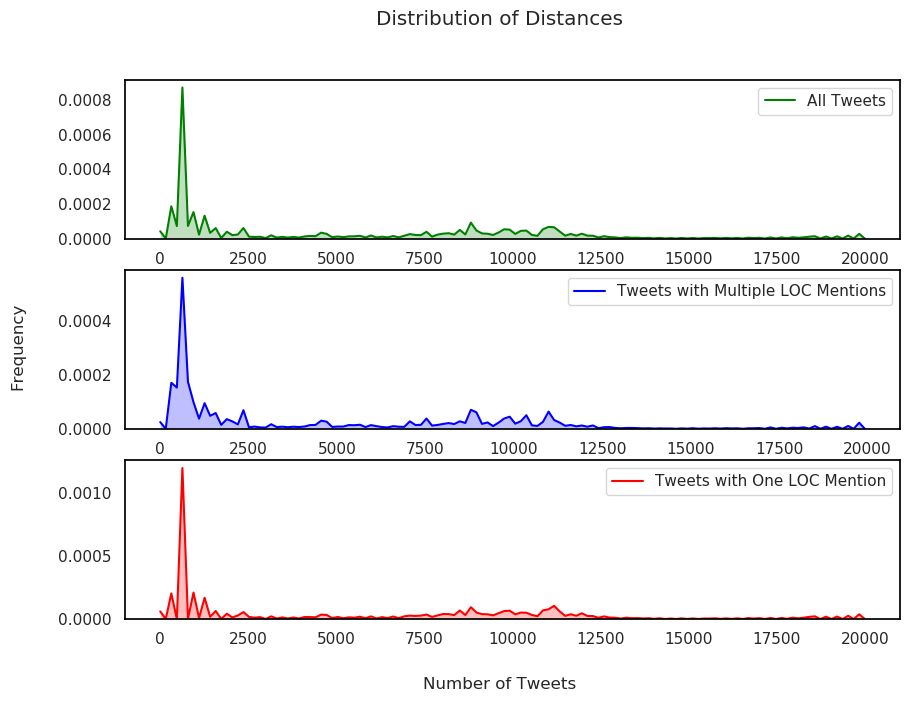

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size and style
sns.set(rc={'figure.figsize':(10,7)})
sns.set_style(style={'axes.edgecolor': 'black', 'axes.facecolor': 'white'})

fig, axes = plt.subplots(3, 1)
fig.suptitle('Distribution of Distances')

# Plot the density plot of the "distance" column
sns.kdeplot(data = nandistance, cut=0, bw=50, shade=True, color="green", ax=axes[0], label="All Tweets")
            #ddf['distance'],
             #color='black', kde=False)
sns.kdeplot(data = ddf_duplicates['distance'], cut=0, bw=50, shade=True, color="blue", ax=axes[1], label="Tweets with Multiple LOC Mentions")
            #ddf['distance'],
             #color='black', kde=False)

sns.kdeplot(data = ddf_noduplicates['distance'], cut=0, bw=50, shade=True, color="red", ax=axes[2], label="Tweets with One LOC Mention")
            #ddf['distance'],
             #color='black', kde=False)


# Rename axis labels

#plt.ylabel('Density')
#plt.xlabel('Distance (km)')

fig.text(0.5, 0.01, 'Number of Tweets', ha='center')
fig.text(0.01, 0.5, 'Frequency', va='center', rotation='vertical')

#fig.set(xlabel='Density', ylabel='Distance (km)')

plt.savefig('distance_frequency.png')
plt.show()

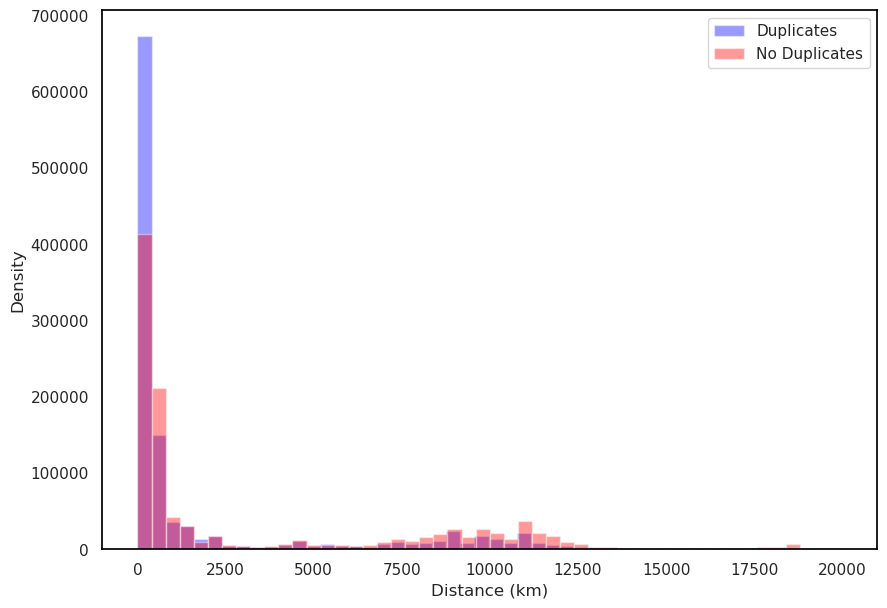

In [16]:
"""
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size and style
sns.set(rc={'figure.figsize':(10,7)})
sns.set_style(style={'axes.edgecolor': 'black', 'axes.facecolor': 'white'})

# Plot the density plot of the "distance" column from ddf_duplicates
sns.distplot(ddf_duplicates['distance'], color='blue', label='Duplicates', kde=False)

# Plot the density plot of the "distance" column from ddf_noduplicates
sns.distplot(ddf_noduplicates['distance'], color='red', label='No Duplicates', kde=False)

# Rename axis labels
plt.xlabel('Distance (km)')
plt.ylabel('Density')

# Add legend
plt.legend()
plt.savefig('distance_dup_frequency.png')
plt.show()
"""

# How many times do countries match?

In [302]:
# check if country names are the same
gdf = ddf[pd.notnull(ddf.country)]
mentioned_ = gdf.country.value_counts(dropna=False).rename_axis('country').reset_index(name='mentioned')
mentioned_

,country,mentioned
0,Argentina,1333231
1,USA,250803
2,Brazil,66076
3,Chile,50790
4,Spain,41092
...,...,...
440,Caucasus,1
441,Kiribati,1
442,Rhône,1
443,Singapore 699014,1


In [303]:
gdf.loc[ddf.place_country == "United States", "place_country"] = "USA"
geotagged_ = gdf.place_country.value_counts(dropna=False).rename_axis('country').reset_index(name='geotagged')
geotagged_

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,country,geotagged
0,Argentina,1950798
1,USA,71929
2,Brazil,34746
3,NaN,29212
4,Chile,27139
...,...,...
196,Turks and Caicos Islands,1
197,Saint Kitts and Nevis,1
198,Federated States of Micronesia,1
199,Tonga,1


In [304]:
merged = geotagged_.merge(mentioned_, how="inner", on="country")

In [79]:
merged.geotagged.sum()

2193081

In [80]:
merged.mentioned.sum()

2112000

In [85]:
import numpy as np

mask = np.where(gdf.place_country == gdf.country, True, False)
matching_countries = gdf[mask]

In [88]:
matching_countries_ = matching_countries.drop_duplicates(["id"])

In [92]:
print("Of the ", t2.shape[0], " tweets with both a geotag and a geoparsed location, \n",
     matching_countries_.shape[0], " tweets have at least one matching country.\n\n",
     "Considering the duplicate mentions too, of the ",ddf[pd.notnull(ddf.country)].shape[0],
      " mentioned location countries\n",
      matching_countries.shape[0], " corresponded with the geotagged country.")

Of the  1722811  tweets with both a geotag and a geoparsed location, 
 1190520  tweets have at least one matching country.

 Considering the duplicate mentions too, of the  2230235  mentioned location countries
 1512941  corresponded with the geotagged country.


# -- Epi Week -- | -- Username -- | -- Mentioned -- | -- Geotagged --

In [94]:
df = ddf[pd.notnull(ddf.country)]
df

,id,DateTime,coordinates,place,username,user_id,user_location,tweet_content,lang,tweet_clean,...,gmaps_lat,gmaps_long,gmaps_address,distance,epi_week,split_address,country,subcountry,granularity,city/town
0,667792991982116864,2015-11-20 19:53:50+00:00,"Coordinates(longitude=-57.5548331, latitude=-3...","Place(fullName='Mar del Plata, Argentina', nam...",darcena2553,2358639522,No soy unica soy diferente,#Acuopolis https://t.co/9Wa5WQmezz,qme,Acuopolis,...,40.456663,-3.990413,"Av. Dehesa, s/n, 28691 Villanueva de la Cañada...",10263.000004,201547,"[Av. Dehesa, s/n, 28691 Villanueva de la Cañad...",Spain,28691 Villanueva de la Cañada,address,NaN
1,671492423734939648,2015-12-01 00:54:04+00:00,"Coordinates(longitude=-62.889222, latitude=-34...","Place(fullName='Santa Fe, Argentina', name='Sa...",LuchoCinqui10,3914185529,,@HDF_ESPN Saludos desde Santa Fe Galvez Muy Bu...,es,Saludos desde Santa Fe Galvez Muy Buen Progra...,...,35.686975,-105.937799,"Santa Fe, NM, USA",8954.693094,201549,"[Santa Fe, NM, USA]",USA,NM,city/town,Santa Fe
2,671493846749065216,2015-12-01 00:59:43+00:00,"Coordinates(longitude=-60.2628441, latitude=-3...","Place(fullName='Buenos Aires, Argentina', name...",lucas_teti,1535237646,Argentina,"no dudo que se va a repetir este viaje, herman...",es,"no dudo que se va a repetir este viaje, herman...",...,-24.782127,-65.423198,"Salta, Salta Province, Argentina",1166.637753,201549,"[Salta, Salta Province, Argentina]",Argentina,Salta Province,city/town,Salta
3,668271432682577920,2015-11-22 03:35:00+00:00,"Coordinates(longitude=-58.4200895, latitude=-3...",Place(fullName='Ciudad Autónoma de Buenos Aire...,lucas_teti,1535237646,Argentina,feo asado te mandaste flaqui 👌 @ Club Geba Pal...,es,feo asado te mandaste flaqui @ Club Geba Palermo,...,38.11569,13.361487,"Palermo, PA, Italy",10933.542601,201547,"[Palermo, PA, Italy]",Italy,PA,city/town,Palermo
4,666014821008166912,2015-11-15 22:08:01+00:00,"Coordinates(longitude=-58.43818626, latitude=-...",Place(fullName='Ciudad Autónoma de Buenos Aire...,lucas_teti,1535237646,Argentina,Con la mejor mesera de pani 🍰🎂 @ Pani Palermo ...,es,Con la mejor mesera de pani @ Pani Palermo Cas...,...,38.11569,13.361487,"Palermo, PA, Italy",10935.524726,201546,"[Palermo, PA, Italy]",Italy,PA,city/town,Palermo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4061086,726905116083761152,2016-05-01 22:44:19+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Domingggo @ Santa Teresita La Costa https://t....,it,Domingggo @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,Buenos Aires Province,city/town,Santa Teresita
4061087,726895962250170368,2016-05-01 22:07:57+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Domingogo. @ Santa Teresita La Costa https://t...,it,Domingogo. @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,Buenos Aires Province,city/town,Santa Teresita
4061088,726892175850635264,2016-05-01 21:52:54+00:00,"Coordinates(longitude=-56.68988656, latitude=-...","Place(fullName='La Costa, Argentina', name='La...",ludmi526,3224699505,"La Costa, Argentina",Muuuy Domingo. @ Santa Teresita La Costa https...,es,Muuuy Domingo. @ Santa Teresita La Costa,...,-36.544051,-56.690393,"Santa Teresita, Buenos Aires Province, Argentina",0.569563,201617,"[Santa Teresita, Buenos Aires Province, Argent...",Argentina,Buenos Aires Province,city/town,Santa Teresita
4061089,724364680278491136,2016-04-24 22:29:32+00:00,"Coordinates(longitude=-56.68988962, latitude=-...","Place(fullName='La Costa, Argentina', name='

In [103]:
mentioned = df.groupby(['username', "epi_week"])["country"].unique().reset_index(name='mentioned').explode("mentioned")
geotagged = df.groupby(['username', "epi_week"])["place_country"].unique().reset_index(name='geotagged').explode("geotagged")

In [145]:
from itertools import product

combined_ = geotagged.merge(mentioned, how="outer", on=["username", "epi_week"])

loc_temp = pd.DataFrame(list(product(combined_.username.unique(), combined_.epi_week.unique())), columns=['username', 'epi_week'])
loc_temp["geotagged"] = None
loc_temp["mentioned"] = None

combined = pd.concat([combined_, loc_temp]).drop_duplicates()#, ignore_index=True)
combined = combined.sort_values(["username","epi_week"], ascending=True)
combined

,username,epi_week,geotagged,mentioned
5,006RodriguezL,201540,None,None
6,006RodriguezL,201541,None,None
7,006RodriguezL,201542,None,None
8,006RodriguezL,201543,None,None
9,006RodriguezL,201544,None,None
...,...,...,...,...
4228070,zzito_,201640,None,None
4228077,zzito_,201641,None,None
4228079,zzito_,201642,None,None
4228080,zzito_,201643,None,None


In [139]:
combined.describe()

,username,epi_week,geotagged,mentioned
count,5592263,5592263,1350761,1364179
unique,72898,58,200,445
top,dancedeets,201547,Argentina,Argentina
freq,170893,104455,917508,462921


# When are mentions and geotags equal?

In [165]:
mask = np.where(combined.geotagged == combined.mentioned, True, False)
t3 = combined[mask]
t3 = t3.groupby(["geotagged", "mentioned"])["epi_week"].count().reset_index(name='counts').explode("counts").sort_values(by="counts", ascending=False)
t3

,geotagged,mentioned,counts
7,Argentina,Argentina,444333
151,USA,USA,7152
24,Brazil,Brazil,6620
34,Chile,Chile,3646
156,Uruguay,Uruguay,2349
...,...,...,...
148,Trinidad and Tobago,Trinidad and Tobago,1
126,San Marino,San Marino,1
147,Tonga,Tonga,1
124,Rwanda,Rwanda,1


In [166]:
t3.counts.sum()

482741

# When are mentions and geotags not equal?

In [167]:
mask = np.where(combined.geotagged != combined.mentioned, True, False)
t4 = combined[mask]
t4 = t4.groupby(["geotagged", "mentioned"])["epi_week"].count().reset_index(name='counts').explode("counts").sort_values(by="counts", ascending=False)
t4

,geotagged,mentioned,counts
1435,Argentina,USA,126511
1124,Argentina,Brazil,28233
1235,Argentina,Italy,27680
1398,Argentina,Spain,25060
1146,Argentina,Chile,20070
...,...,...,...
23513,Switzerland,Central African Republic,1
17782,Norway,Qatar,1
13697,Lebanon,United Arab Emirates,1
9769,Guatemala,Vietnam,1


In [168]:
t4.counts.sum()

868020

# If mention is Argentina, where are the users?

In [403]:
temp = combined_.loc[combined_.mentioned == "Argentina", "geotagged"].value_counts().rename_axis('country').reset_index(name='counts')
temp

,country,counts
0,Argentina,444333
1,Brazil,2454
2,USA,2344
3,Chile,1476
4,Uruguay,874
...,...,...
183,Falkland Islands (Malvinas),1
184,Liechtenstein,1
185,Rwanda,1
186,Federated States of Micronesia,1


In [404]:
temp = combined_.loc[combined_.mentioned == "Argentina", "geotagged"].value_counts().rename_axis('country').reset_index(name='counts')
temp = temp[temp.country != "Argentina"]

total_loc = temp.counts.sum()
temp["prop"] = temp["counts"]/total_loc

n = 20

temp_keep = temp[0:n]
discarded = temp[n:temp.shape[0]]

temp_keep.loc[n, "country"] = "Other"
temp_keep.loc[n, "counts"] = discarded.counts.sum()
temp_keep.loc[n, "prop"] = temp_keep.loc[n, "counts"] / total_loc

temp = temp_keep
common_countries = temp

temp

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,country,counts,prop
1,Brazil,2454,0.136409
2,USA,2344,0.130295
3,Chile,1476,0.082046
4,Uruguay,874,0.048583
5,Mexico,682,0.037910
6,Spain,623,0.034630
7,Peru,456,0.025347
8,Paraguay,445,0.024736
9,Italy,363,0.020178
10,France,337,0.018733


# If the geotag is Argentina, which countries are users mentioning?

In [405]:
temp = combined_.loc[combined_.geotagged == "Argentina", "mentioned"].value_counts(dropna=False).rename_axis('country').reset_index(name='counts')
temp = temp[temp.country != "Argentina"]

total_loc = temp.counts.sum()
temp["prop"] = temp["counts"]/total_loc

n = 20

temp_keep = temp[0:n]
discarded = temp[n:temp.shape[0]]

temp_keep.loc[n, "country"] = "Other"
temp_keep.loc[n, "counts"] = discarded.counts.sum()
temp_keep.loc[n, "prop"] = temp_keep.loc[n, "counts"] / total_loc

temp = temp_keep
common_countries = temp

temp

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,country,counts,prop
1,USA,126511,0.267366
2,Brazil,28233,0.059667
3,Italy,27680,0.058498
4,Spain,25060,0.052961
5,Chile,20070,0.042416
6,Mexico,18613,0.039336
7,France,16267,0.034378
8,United States,11555,0.024420
9,Colombia,11449,0.024196
10,Uruguay,8679,0.018342


# Heatmap of mentions and geotags

In [457]:
n = 28

r = set(mentioned_.country[0:n].tolist())
s = set(geotagged_.country[0:n].tolist())

lst = list(r.intersection(s))
len(lst)

20

In [458]:
t5 = combined_[(combined_.geotagged.isin(lst)) & (combined_.mentioned.isin(lst))]
t5 = t5.groupby(["geotagged", "mentioned"])["epi_week"].count().reset_index(name='counts').sort_values(by=["geotagged", "mentioned"], ascending=False)
t5 = pd.pivot(t5, index="mentioned", columns="geotagged", values="counts").T
t5.loc["Argentina", "Argentina"] = 1
t5

mentioned,Argentina,Australia,Brazil,Canada,Chile,Colombia,Ecuador,France,Germany,Italy,Japan,Mexico,Paraguay,Peru,Spain,Switzerland,Taiwan,USA,Uruguay,Venezuela
geotagged,,,,,,,,,,,,,,,,,,,,
Argentina,1,4958,28233,3156,20070,11449,4402,16267,5126,27680,5562,18613,5325,5891,25060,3465,3087,126511,8679,8553
Australia,164,274,125,124,102,77,44,86,79,76,94,108,15,94,88,61,66,152,24,47
Brazil,2454,143,6620,190,189,189,43,190,154,204,107,254,102,113,230,93,107,891,142,86
Canada,195,156,125,258,146,107,58,99,83,107,140,164,27,139,134,67,93,220,22,63
Chile,1476,148,210,149,3646,500,106,128,129,184,236,361,35,297,330,68,132,1112,56,143
Colombia,335,97,112,104,131,1063,58,68,52,80,111,142,22,123,118,41,65,300,18,171
Ecuador,262,76,70,62,119,86,452,52,34,71,72,106,18,87,117,23,38,223,42,48
France,337,89,103,86,79,69,25,864,113,175,69,89,14,65,180,76,60,317,28,31
Germany,171,79,94,79,68,57,28,109,424,97,69,74,4,64,113,70,60,130,26,30


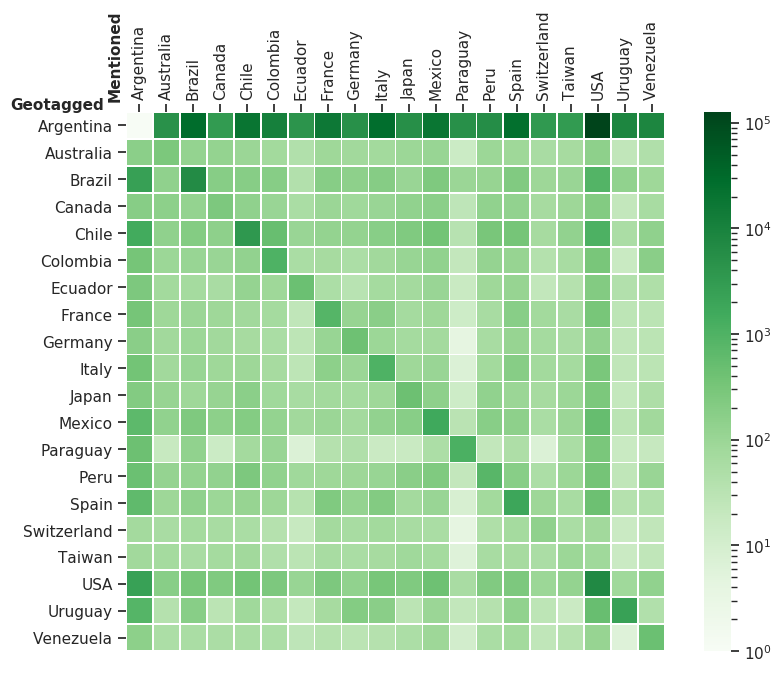

In [460]:
from matplotlib.colors import LogNorm
fig = plt.figure()#figsize=(10,10))

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.rcParams['ytick.left'] = plt.rcParams['xtick.labeltop'] = True

fig.text(0.195, 0.9, 'Mentioned', ha='center', fontsize=11, fontweight="bold", rotation='vertical')
fig.text(0.5, 0.07, 'hj', ha='center', color="white")
fig.text(0.09, 0.89, 'Geotagged', va='center', #rotation='vertical',
         fontsize=11, fontweight="bold")

#sns.color_palette("crest")#, as_cmap=True)
ax = sns.heatmap(t5, norm=LogNorm(), cmap="Greens",
                 square=True, linewidth=.5).set(#title="Mentioned vs Geotagged Countries",
                                               xlabel="",ylabel="", )
#ax.xaxis.label.set_color('white')

#fig.savefig("distance-heatmap.png")
plt.show()

In [131]:
combined.username.unique()[50234:50254]

array(['dcuga', 'ddaengjongin', 'ddaimiranda', 'ddaiperezz', 'ddaisy057',
       'ddalma_', 'ddanielcruz_', 'ddannig', 'ddantoledo', 'ddcelesty',
       'dddddelma', 'dddddlfn', 'dddelfinag', 'ddelfiaguirre',
       'ddhipolito', 'ddiegomartin', 'ddoloresrocio', 'ddonna58',
       'dduarteang', 'ddupont4'], dtype=object)

In [141]:
# death threats - dddddlfn
# event promoter - dancedeets
# A Google satellite view from a completely random land location on Earth every few hours. - BPEarth
combined[(combined.username == "dancedeets") & (pd.notnull(combined.geotagged) & (pd.notnull(combined.mentioned)))]

,username,epi_week,geotagged,mentioned
851559,dancedeets,201540,USA,USA
851560,dancedeets,201540,USA,United States
851561,dancedeets,201540,USA,Netherlands
851562,dancedeets,201540,USA,Finland
851563,dancedeets,201540,USA,Germany
...,...,...,...,...
1022389,dancedeets,201644,The Netherlands,Portugal
1022390,dancedeets,201644,The Netherlands,Bolivia
1022391,dancedeets,201644,The Netherlands,Sweden
1022392,dancedeets,201644,The Netherlands,Peru


In [149]:
tt = combined_.groupby(["username"])["epi_week"].count().reset_index(name='mentioned')
tt[tt.mentioned > 10*len(combined.epi_week.unique())]

,username,mentioned
84,1000_Caracteres,600
1184,AgenciaAJN,611
5295,BPEarth,114879
11493,Djabal,2701
26392,Manthai2009,14871
32690,Nuestromar,583
34559,QuakesToday,49546
34565,QuePasaSalta,887
37545,SismoG140,1593
41182,Whady,1085


In [143]:
len(combined.epi_week.unique())

58

In [142]:
pd.set_option('max_colwidth', None)
t1.loc[t1.username == "dancedeets", "tweet_clean"]

3728249        2016/11/16: Al Danah, Abu Dhabi, United Arab Emirates: Balkan Night feat. Milica Pavlovic 
3728252                     2016/11/29: Taichung City, Taiwan: 11/29 All Style Battle Vol.8 in HungKuang 
3728255      2016/11/13: Brooklyn, NY, United States: 718 Sessions | Danny Krivit (Open to Close) at Out 
3728258                                           2016/12/04: Helsinki, Finland: JR Black Eagle Workshop 
3728260             2016/11/02: Manhattan, New York, NY, United States: RootsNYC w/Louie Vega ALL NIGHT! 
                                                        ...                                              
3793925                                   2015/10/10: Bayamn, Puerto Rico: OPEN HOUSE REAL EMPIRE STUDIO 
3793927              2015/10/03: Fazendinha/Porto, Curitiba, Brazil: Workshop Bgirl Bibi e Bboy Master D 
3793931    2015/10/12: Manhattan, New York, NY, United States: JUMP N FUNK meets FUNKBOX SUNDAY OCT 11TH 
3793935                          2015/10/11: P

In [120]:
loc_temp

,username,epi_week,geotagged,mentioned
0,006RodriguezL,201615,None,None
1,006RodriguezL,201617,None,None
2,006RodriguezL,201620,None,None
3,006RodriguezL,201623,None,None
4,006RodriguezL,201547,None,None
...,...,...,...,...
4228079,zzito_,201642,None,None
4228080,zzito_,201643,None,None
4228081,zzito_,201626,None,None
4228082,zzito_,201616,None,None


In [117]:
combined.isna().sum()

username           0
epi_week           0
mentioned    4228084
geotagged    4241502
dtype: int64

In [110]:
combined[combined.geotagged == "Argentina"]

,username,epi_week,mentioned,geotagged
0,006RodriguezL,201615,USA,Argentina
1,006RodriguezL,201615,Argentina,Argentina
2,006RodriguezL,201617,USA,Argentina
3,006RodriguezL,201620,Honduras,Argentina
4,006RodriguezL,201620,USA,Argentina
...,...,...,...,...
1364174,zzito_,201605,Argentina,Argentina
1364175,zzito_,201608,Switzerland,Argentina
1364176,zzito_,201609,Argentina,Argentina
1364177,zzito_,201610,Argentina,Argentina


In [115]:
ar_g = combined[combined.geotagged == "Brazil"]
ar_g.mentioned.value_counts()

Brazil            6620
Argentina         2454
USA                891
Cabo Verde         283
Portugal           255
                  ... 
North America        1
Eastern Europe       1
New Guinea           1
314201               1
Maldives             1
Name: mentioned, Length: 247, dtype: int64

In [113]:
combined[combined.mentioned == "Argentina"]

,username,epi_week,mentioned,geotagged
1,006RodriguezL,201615,Argentina,Argentina
8,007_h,201540,Argentina,Argentina
40,007_h,201541,Argentina,Argentina
59,007_h,201542,Argentina,Argentina
86,007_h,201543,Argentina,Argentina
...,...,...,...,...
1364170,zzito_,201603,Argentina,Argentina
1364172,zzito_,201604,Argentina,Argentina
1364174,zzito_,201605,Argentina,Argentina
1364176,zzito_,201609,Argentina,Argentina


In [112]:
ar = combined[combined.mentioned == "Argentina"]

mask = np.where(ar.geotagged == "Argentina", True, False)
ar[mask]

,username,epi_week,mentioned,geotagged
1,006RodriguezL,201615,Argentina,Argentina
8,007_h,201540,Argentina,Argentina
40,007_h,201541,Argentina,Argentina
59,007_h,201542,Argentina,Argentina
86,007_h,201543,Argentina,Argentina
...,...,...,...,...
1364170,zzito_,201603,Argentina,Argentina
1364172,zzito_,201604,Argentina,Argentina
1364174,zzito_,201605,Argentina,Argentina
1364176,zzito_,201609,Argentina,Argentina
